In [1]:
import re, time, warnings, os, sys, copy
from typing import Union, Dict
import gzip, pickle

import numpy as np
import pandas as pd
import gzip, pickle
import scipy, sklearn, mne

import auxiliary as aux
import data, rsa
sys.path.append('../spaces/')
import embeddings as emb
import pubplot as pub
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

In [2]:
from subject_rsa_rec import load_eeg
from inference_rsa_rec import _plot_topo_inlay
from subject_rerp_mt1 import load_annotation

In [3]:
# load reconstruction data
with gzip.open(f'./data/results/reconstruction.pkl.gz', 'rb') as f:
    r, p, rec = pickle.load(f)

# load encoding data
with gzip.open(f'./data/results/encoding_b0-m0-c0-k5.pkl.gz', 'rb') as f:
    r_a, ß_a, r_s, ß_s, r_as, ß_as, one_samp, contrasts, cluster_based = pickle.load(f)

# load sample eeg data
sub = data.Subjects['0002']
sid, pid = sub.sid, sub.pid
eeg, info = load_eeg(f'./data/preprocessed/eeg/sub{sid}/rsa-MT1-epo.fif', fs = 200)
dir_out = f'./data/processed/eeg/sub{sid}/'

with gzip.open(f'{dir_out}rec-data.pkl.gz', 'rb') as f:
    (r_i, _, labels, _, _, _, y, y_t, y_a, y_h_mt1, _) = pickle.load(f)

# load sample behaviour
df = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv')
beh = df.loc[(df.type == data.defs.TRIAL_MT_MAIN) | (df.type == data.defs.TRIAL_MT_CONTROL) | (df.type == data.defs.TRIAL_MT_PRACTICE)].reset_index(drop = True)

# load sample priors
context = np.array(beh.context.tolist())[-1]
with gzip.open(f'./data/raw/rtfe/sub{sid}/{pid}_t263_{context}.pkl.gz', 'rb') as f:
    _, _, _, posterior, _, _ = pickle.load(f)
priors = posterior.T

# load embedding
G = emb.glove.load_embedding(f_in = './data/preprocessed/misc/glove/w2v_50D.txt') # mini version

# setup contexts & priors
contexts = np.array(['essen', 'fashion', 'outdoor', 'technik', 'politik', 'unterhaltung'])

with gzip.open(f'./data/raw/rtfe-unspecific/sub{sid}/{pid}_t263_essen.pkl.gz', 'rb') as f:
    _, _, _, posterior, _, _ = pickle.load(f)
priors_uns = posterior.T
    
# load all words
words = np.array(beh.options_0.tolist())
speakers = np.array(beh.context.tolist())
embeddings = np.array([G[word.lower()] for word in words])

# load projected priors
X_w, X_u, X_p = np.load(f'./figures/resources/fig1_priors.npy', allow_pickle = True)

In [4]:
from subject_rerp_mt1 import load_annotation

# load word onsets & offsets quickly
mt = beh.loc[(beh.type == data.defs.TRIAL_MT_MAIN)].reset_index(drop = True)

onsets = []
offsets = []
durations = []

for i in range(len(mt)):
    trial = mt.loc[i]
    stim = '.'.join(trial.stimulus.split('/')[-1].split('.')[0:-1])
    
    a = load_annotation(f'./data/preprocessed/audio/annotated/morphed/{stim}_A.csv', fs = 200)
    b = load_annotation(f'./data/preprocessed/audio/annotated/morphed/{stim}_B.csv', fs = 200)
    
    onsets.append(a.loc[0].onset)
    offsets.append(a.loc[len(a)-1].offset)
    
    onsets.append(b.loc[0].onset)
    offsets.append(b.loc[len(b)-1].offset)
    
    durations.append(trial.duration)

onsets = np.array(onsets)
offsets = np.array(offsets)

on_pct_md, on_pct_lb, on_pct_ub = np.median(onsets), np.percentile(onsets, 2.5), np.percentile(onsets, 97.5)
off_pct_md, off_pct_lb, off_pct_ub = np.median(offsets), np.percentile(offsets, 2.5), np.percentile(offsets, 97.5)

print(on_pct_md, on_pct_lb, on_pct_ub)
print(off_pct_md, off_pct_lb, off_pct_ub)
print(np.mean(durations))

9.0 0.0 25.049999999999955
166.0 94.0 218.19999999999982
0.8669250000000001


/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_40531/4120580891.py:258: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax_cb.contourf(cb_x, cb_y, cb_y, cmap = 'gray', aspect = 'auto', interpolation = 'gaussian', levels = 100)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b4/qysvl6jd4995kp_qql3yj3880000gn/T/ipykernel_40531/4120580891.py:673: UserWarning: The following kwargs were not used by contour: 'aspect', 'interpolation'
  ax_cb2.contourf(cb_x, cb_y, cb_x, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)


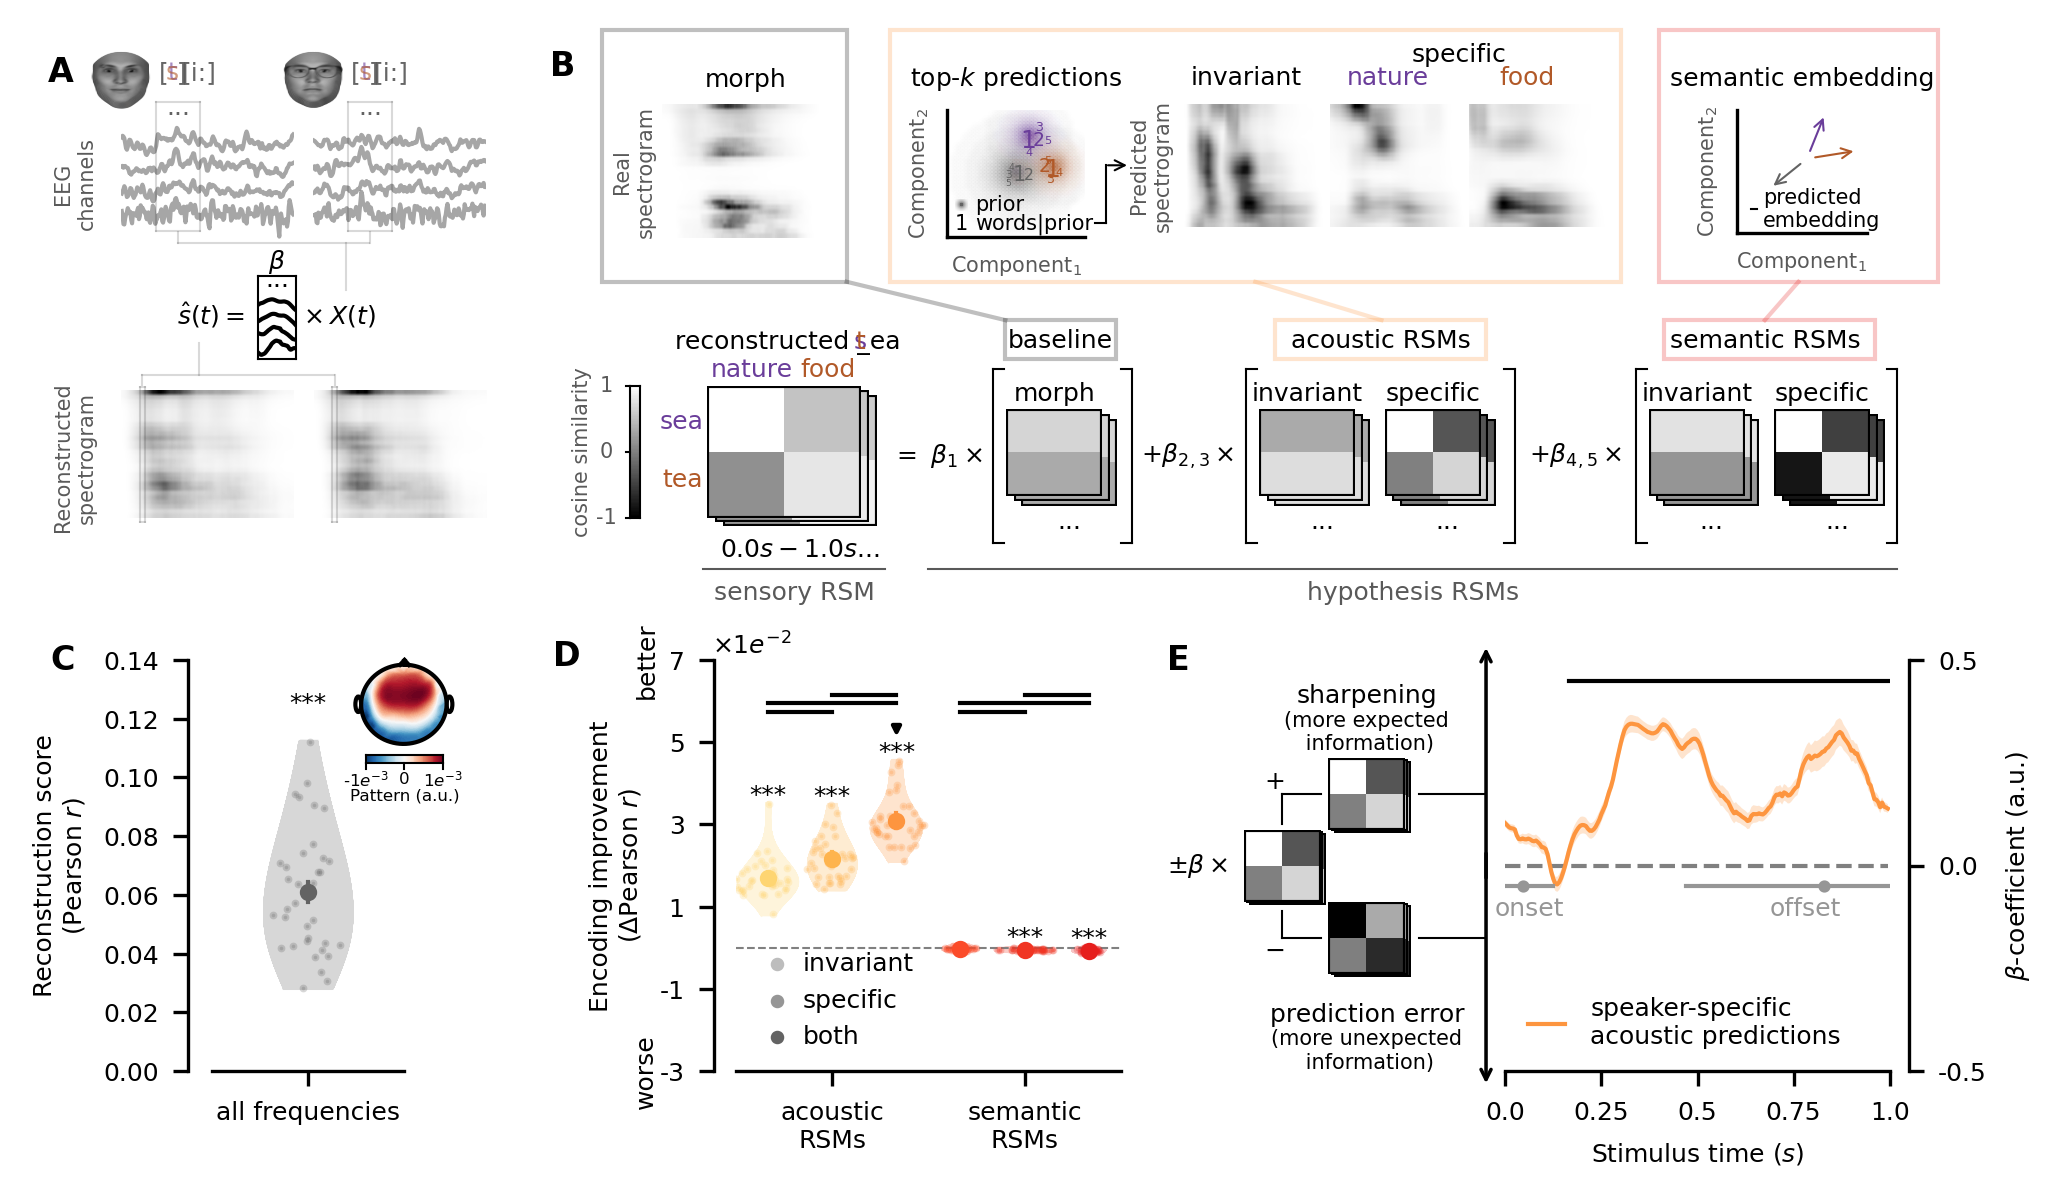

In [ ]:
import seaborn as sns

C_s = pub.colours.equidistant('Paired', k = 12)
C = pub.colours.equidistant('tab20c', k = 20)

context_labels = dict(outdoor = 'nature', essen = 'food', fashion = 'fashion',
                      politik = 'politics', unterhaltung = 'arts', technik = 'tech')
order = np.array(['outdoor', 'essen', 'fashion', 'politik', 'unterhaltung', 'technik'])

show_annotation = True
show_speakers = True

show_rdms = 3
show_rdms_skip = 5
show_rdms_start = 40

ci = 1.96

trial = 'See-Tee_1-1_12ch_0.50_r1_cs'
trial_a = 'See-Tee_T1'
trial_b = 'See-Tee_D1'
phonemes_eng_a = ['[t]', '[i:]']
phonemes_eng_b = ['[s]', '[i:]']
phonemes_crit = [0]

indx = np.where(labels == trial)[0]
TRIAL, OTHER = indx

import matplotlib
C1 = pub.colours.equidistant('YlOrRd', k = 20)
cols_inv = [C1[5], C1[12], C1[10]]
cols_spc = [C1[7], C1[13], C1[11]]
cols_bot = [C1[9], C1[14], C1[12]]

colours = dict(outdoor = C_s[9], essen = C_s[11], fashion = C_s[5], 
               politik = C_s[7], unterhaltung = C_s[1], technik = C_s[3])

fig, ax = pub.figure(figsize = (7.0, 4.0))

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.axis('off')

# setup (some) axes
ax_chs = ax.inset_axes([0.03, 0.815, 0.09, 0.15])
ax_chs2 = ax.inset_axes([0.13, 0.815, 0.09, 0.15])
ax_fts = ax.inset_axes([0.03, 0.565, 0.09, 0.125])
ax_fts2 = ax.inset_axes([0.13, 0.565, 0.09, 0.125])
ax_chs_lab = ax.inset_axes([0.0, 0.8, 0.05, 0.2])
ax_fts_lab = ax.inset_axes([0.0, 0.55, 0.05, 0.2])
ax_fil = ax.inset_axes([0.0, 0.47, 0.25, 0.13])

ax_rsa1 = ax.inset_axes([0.25, 0.47, 0.25, 0.13])
ax_rsa2 = ax.inset_axes([0.295, 0.55, 0.2, 0.2])
ax_rsa_ex = ax.inset_axes([0.275, 0.75, 0.725, 0.25])

ax_enc = ax.inset_axes([0.45, 0.47, 0.45, 0.53])

ax_fil.axis('off')
ax_rsa1.axis('off')
ax_rsa2.axis('off')
ax_rsa_ex.axis('off')
ax_enc.axis('off')

'''
plot eeg channels
'''

for i in np.arange(0, 4, 1):
    # plot eeg
    ax_chs.plot(eeg[TRIAL,i,100:300] + i * np.abs(eeg[TRIAL,:,:]).max(), color = 'black', alpha = 0.35)
    ax_chs2.plot(eeg[OTHER,i,100:300] + i * np.abs(eeg[TRIAL,:,:]).max(), color = 'black', alpha = 0.35)

for ax_i in [ax_chs, ax_chs2]:
    if show_speakers:
        ax_s0 = ax_chs.inset_axes([-0.175, 0.85, 0.35, 0.35]); ax_s0.axis('off')
        pub.graphs.procedure([dict(T = 'image-only', stimulus = './data/raw/misc/faces/face7_piercing2.png', delay = '', duration = r'', style = dict(color = 'white', scatter = dict(alpha = 1.0)))], ax = ax_s0)

        ax_s1 = ax_chs2.inset_axes([-0.175, 0.85, 0.35, 0.35]); ax_s1.axis('off')
        pub.graphs.procedure([dict(T = 'image-only', stimulus = './data/raw/misc/faces/face12_glasses3.png', delay = '', duration = r'', style = dict(color = 'white', scatter = dict(alpha = 1.0)))], ax = ax_s1)

    if show_annotation:
        ann_a = load_annotation(f'./data/preprocessed/audio/annotated/morphed/{trial}_A.csv', fs = 200)

        for i in range(len(ann_a)):
            if i in phonemes_crit:
                ax_i.annotate('[ ]', xy = (0, 0), xytext = (ann_a.loc[i].onset + 40 + (i > 0) * 25, 6.0 * np.abs(eeg[TRIAL,:,:]).max()), ha = 'center', va = 'center', alpha = 0.6)
                ax_i.annotate(phonemes_eng_a[i][1:-1], xy = (0, 0), xytext = (ann_a.loc[i].onset + 40 + (i > 0) * 25, 6.0 * np.abs(eeg[TRIAL,:,:]).max()), color = colours['outdoor'], ha = 'center', va = 'center', alpha = 0.6)
                ax_i.annotate(phonemes_eng_b[i][1:-1], xy = (0, 0), xytext = (ann_a.loc[i].onset + 40 + (i > 0) * 25, 6.0 * np.abs(eeg[TRIAL,:,:]).max()), color = colours['essen'], ha = 'center', va = 'center', alpha = 0.6)
            else:
                ax_i.annotate(phonemes_eng_a[i], xy = (0, 0), xytext = (ann_a.loc[i].onset + 40 + (i > 0) * 25, 6.0 * np.abs(eeg[TRIAL,:,:]).max()), ha = 'center', va = 'center', alpha = 0.6)

    ax_i.annotate('...', color = C[16], xy = (65.5, 4 * np.abs(eeg[TRIAL,:,:]).max()), xytext = (65.5, 4.5 * np.abs(eeg[TRIAL,:,:]).max()), ha = 'center', va = 'center')
    ax_i.set_ylim([-1.5 * np.abs(eeg[TRIAL,:,:]).max(), 5.5 * np.abs(eeg[TRIAL,:,:]).max()])
    ax_i.set_xlim([-1, 200])
    
    ax_i.plot([40, 91], [-0.75 * np.abs(eeg[TRIAL,:,:]).max(), -0.75 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, alpha = 0.15)
    ax_i.plot([40, 91], [4.75 * np.abs(eeg[TRIAL,:,:]).max(), 4.75 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, alpha = 0.15)
    ax_i.plot([40, 40], [-0.75 * np.abs(eeg[TRIAL,:,:]).max(), 4.75 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, alpha = 0.15)
    ax_i.plot([91, 91], [-0.75 * np.abs(eeg[TRIAL,:,:]).max(), 4.75 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, alpha = 0.15)
    
    ax_i.axis('off')

ax_chs_lab.set_xlim([0, 1])
ax_chs_lab.set_ylim([0, 1])
ax_chs_lab.annotate('\nEEG\nchannels', annotation_clip = False, color = 'black', alpha = 0.65, fontsize = 5, xy = (0, 0.5), xytext = (0, 0.375), rotation = 90, ha = 'center', va = 'center')
ax_chs_lab.axis('off')

'''
plot gammatone
'''

indx = np.where(labels == trial)[0]

tests = y_h_mt1[indx,:,:]
tests = tests / np.abs(y).max(axis = (0, 2))[None,:,None]
tests = np.exp(2.5 * tests) / np.exp(2.5 * tests).sum()

test_gt0 = tests[0,:,:]
test_gt1 = tests[1,:,:]

ax_fts.imshow(test_gt0, origin = 'lower', cmap = 'gray_r', aspect = 'auto')
ax_fts2.imshow(test_gt1, origin = 'lower', cmap = 'gray_r', aspect = 'auto')

for ax_i in [ax_fts, ax_fts2]:
    ax_i.set_ylim([-1.5, 28.5])
    ax_i.set_xlim([-1, 200])
    ax_i.plot([21, 27], [-1.25, -1.25], color = 'black', linewidth = 0.5, alpha = 0.15)
    ax_i.plot([21, 27], [28.25, 28.25], color = 'black', linewidth = 0.5, alpha = 0.15)
    ax_i.plot([21, 21], [-1.25, 28.25], color = 'black', linewidth = 0.5, alpha = 0.15)
    ax_i.plot([27, 27], [-1.25, 28.25], color = 'black', linewidth = 0.5, alpha = 0.15)
    ax_i.axis('off')

ax_fts_lab.set_xlim([0, 1])
ax_fts_lab.set_ylim([0, 1])
ax_fts_lab.annotate('\nReconstructed\nspectrogram', fontsize = 5, annotation_clip = False, xy = (0, 0.375), xytext = (0, 0.375), rotation = 90, color = 'black', alpha = 0.65, ha = 'center', va = 'center')
ax_fts_lab.axis('off')

'''
add filtering step for rec
'''

filters = p.mean(axis = (0, 1))[:,:]
filters -= filters.mean(axis = 1, keepdims = True)
filters = filters / np.abs(filters).max(axis = 1, keepdims = True)
fmax = 2.0 * np.abs(filters).max()
ax_filter = ax.inset_axes([0.10125, 0.715, 0.02, 0.075]); ax_filter.axis('off')
ax_filter.set_xlim([0, filters.shape[1]])
ax_filter.set_ylim([-0.75 * fmax, 4.75 * fmax])
ax_filter.plot([0, filters.shape[1]], [-0.75 * fmax, -0.75 * fmax], clip_on = False, color = 'black', linewidth = 0.5)
ax_filter.plot([0, filters.shape[1]], [4.75 * fmax, 4.75 * fmax], clip_on = False, color = 'black', linewidth = 0.5)
ax_filter.plot([0, 0], [-0.75 * fmax, 4.75 * fmax], clip_on = False, color = 'black', linewidth = 0.5)
ax_filter.plot([filters.shape[1], filters.shape[1]], [-0.75 * fmax, 4.75 * fmax], clip_on = False, color = 'black', linewidth = 0.5)

for i in range(4):
    ax_filter.plot(i * fmax + filters[i,:], color = 'black')
ax_filter.annotate('...', xy = (0, 0), xytext = (filters.shape[1] / 2, 4.5 * fmax), ha = 'center', va = 'center', annotation_clip = False)
ax_filter.annotate(r'$\beta$', xy = (0, 0), xytext = (filters.shape[1] / 2, 5.75 * fmax), ha = 'center', va = 'center', annotation_clip = False)
ax_chs.annotate(r'$\hat{s}(t) = \quad\quad\times X(t)$', xy = (0, 0), xytext = (180, -4.3 * np.abs(eeg[TRIAL,:,:]).max()), ha = 'center', va = 'center')

ax_chs.plot([65, 65], [-0.8 * np.abs(eeg[TRIAL,:,:]).max(), -1.25 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)
ax_chs2.plot([65, 65], [-0.8 * np.abs(eeg[TRIAL,:,:]).max(), -1.25 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)
ax_chs.plot([65, 287], [-1.25 * np.abs(eeg[TRIAL,:,:]).max(), -1.25 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)
ax_chs.plot([260, 260], [-1.25 * np.abs(eeg[TRIAL,:,:]).max(), -3.25 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)

ax_chs.plot([90, 90], [-5.5 * np.abs(eeg[TRIAL,:,:]).max(), -6.85 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)
ax_chs.plot([24, 24], [-7.3 * np.abs(eeg[TRIAL,:,:]).max(), -6.85 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)
ax_chs2.plot([24, 24], [-7.3 * np.abs(eeg[TRIAL,:,:]).max(), -6.85 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)
ax_chs.plot([24, 246], [-6.85 * np.abs(eeg[TRIAL,:,:]).max(), -6.85 * np.abs(eeg[TRIAL,:,:]).max()], color = 'black', linewidth = 0.5, clip_on = False, alpha = 0.15)

'''
plot decoder
'''

ax_fil.set_xlim([0, 1])
ax_fil.set_ylim([0, 1])
#ax_fil.annotate('Stimulus reconstruction', xy = (0.5, 0.075), xytext = (0.5, 0.075), ha = 'center', va = 'center')
#ax_fil.annotate('', annotation_clip = False, xy = (1.075, 0.075), xytext = (0.85, 0.075), arrowprops=dict(arrowstyle="->"))
ax_fil.axis('off')

'''
plot RSA middle part
'''

ax_rsa1.set_xlim([0, 1])
ax_rsa1.set_ylim([0, 1])
#ax_rsa1.annotate('Representational similarity', xy = (0.45, 0.075), xytext = (0.45, 0.075), ha = 'center', va = 'center')
#ax_rsa1.annotate('', annotation_clip = False, xy = (1.4, 0.075), xytext = (0.84, 0.075), arrowprops=dict(arrowstyle="->"))
ax_rsa1.axis('off')

'''
encoder mid
'''

#ax_enc.annotate('Similarity encoders', xy = (0.5, 0.0), xytext = (0.5, 0.0165), ha = 'center', va = 'center')
ax_enc.set_xlim([0, 1])
ax_enc.set_ylim([0, 1])
ax_enc.axis('off')

'''
RSA observed
'''

# setup subfig
ax_rsa2.set_xlim([0.05, 0.6])
ax_rsa2.set_ylim([0.6, 1])

# add labels (top)
ax_rsa2.annotate('\nreconstructed _ea', xy = (0.275, 0.985), xytext = (0.275, 0.985), annotation_clip = False, ha = 'center', va = 'center')
ax_rsa2.annotate('\ns    ', xy = (0.275, 0.985), xytext = (0.4025, 0.986), color = colours['outdoor'], ha = 'center', va = 'center')
ax_rsa2.annotate('\nt    ', xy = (0.275, 0.985), xytext = (0.4025, 0.986), color = colours['essen'], ha = 'center', va = 'center')
ax_rsa2.annotate('nature', color = colours['outdoor'], xy = (0.165, 0.91), xytext = (0.165, 0.91), ha = 'left', va = 'center')
ax_rsa2.annotate('food', color = colours['essen'], xy = (0.295, 0.91), xytext = (0.2925, 0.91), ha = 'left', va = 'center')

# add labels (left)
ax_rsa2.annotate('sea', color = colours['outdoor'], xy = (0.0915, 0.815), xytext = (0.0915, 0.815), ha = 'left', va = 'center')
ax_rsa2.annotate('tea', color = colours['essen'], xy = (0.0955, 0.71), xytext = (0.0955, 0.71), ha = 'left', va = 'center')

# disable axis
ax_rsa2.axis('off')

def inset_rdms(rdm, x, y, title, ax, show_t = False, size = (0.4, 0.6), offset = 0.02, vmin = 0.0, vmax = 1.0):
    for i in np.arange(show_rdms-1, -1, -1):
        ax_rdm = ax.inset_axes([x + i * offset, y - i * offset, *size])
        ax_rdm.axis('off')
        ax_rdm.imshow(np.flip(rdm[show_rdms_start + show_rdms_skip * i,:,:], axis = 0), vmin = vmin, vmax = vmax, cmap = 'gray', aspect = 'auto', origin = 'lower')

        ax_rdm.plot([-0.5, -0.5], [-0.5, 1.5], color = 'black')
        ax_rdm.plot([1.5, 1.5], [-0.5, 1.5], color = 'black')
        ax_rdm.plot([-0.5, 1.5], [-0.5, -0.5], color = 'black')
        ax_rdm.plot([-0.5, 1.5], [1.5, 1.5], color = 'black')

        if i == 0: ax_rdm.annotate(title, xy = (0.5, 1.85), xytext = (0.5, 1.85), ha = 'center', va = 'center', annotation_clip = False)
        if i == show_rdms-1: 
            if show_t == True: ax_rdm.annotate(r'$0.0s-1.0s$...', xy = (0.5, -0.85), xytext = (0.5, -0.85), ha = 'center', va = 'center', annotation_clip = False)
            elif show_t is None: continue
            else: ax_rdm.annotate('...', xy = (0.5, -0.85), xytext = (0.5, -0.85), ha = 'center', va = 'center', annotation_clip = False)

# add RDM
#rdm_obs = rsa.analysis.compute_rdms([y_h_mt1[TRIAL,:,:], y_h_mt1[OTHER,:,:], y_t[TRIAL,:,:], y_t[OTHER,:,:]], f = rsa.math.cosine)
#rdm_obs = rdm_obs[:,[0, 0, 1, 1],[2, 3, 2, 3]].reshape((200, 2, 2))
rdm_obs = np.array([[0.6, 0.47], [0.37, 0.54]])[None,:,:] * np.ones((200, 2, 2))
rdm_obs = rdm_obs * (1 + 0.75 * np.sin(np.arange(200) * 1e-3 * 2 * np.pi))[:,None,None]
inset_rdms(rdm_obs, 0.20, 0.1, '', ax = ax_rsa2, size = (0.4, 0.6), vmin = 0.1, vmax = 0.7, show_t = True)

# add colorbar
ax_cb = ax_rsa2.inset_axes([0.0, 0.1, 0.025, 0.6])
ax_cb.set_xticks([])
ax_cb.set_yticks([])
ax_cb.set_xlim([0, 1])
ax_cb.set_ylim([-1, 1])
for axis in ['top','bottom','left','right']:
    ax_cb.spines[axis].set_linewidth(0.5)

cb_x = np.linspace(0, 1, 5)
cb_y = np.linspace(-1, 1, 5)
cb_x, cb_y = np.meshgrid(cb_x, cb_y)
ax_cb.contourf(cb_x, cb_y, cb_y, cmap = 'gray', aspect = 'auto', interpolation = 'gaussian', levels = 100)
ax_cb.plot([0, -0.5], [-1, -1], clip_on = False, color = 'black', linewidth = 0.5)
ax_cb.plot([0, -0.5], [0, 0], clip_on = False, color = 'black', linewidth = 0.5)
ax_cb.plot([0, -0.5], [1, 1], clip_on = False, color = 'black', linewidth = 0.5)
ax_cb.annotate('-1', xy = (-1.5, -1), xytext = (-2.5, -1), ha = 'center', va = 'center', fontsize = 5, alpha = 0.65, annotation_clip = False)
ax_cb.annotate('0', xy = (-1.5, 0), xytext = (-2.5, 0), ha = 'center', va = 'center', fontsize = 5, alpha = 0.65, annotation_clip = False)
ax_cb.annotate('1', xy = (-1.5, 1), xytext = (-2.5, 1), ha = 'center', va = 'center', fontsize = 5, alpha = 0.65, annotation_clip = False)
ax_cb.annotate('cosine similarity', xy = (-5.0, 0), xytext = (-5.0, 0), ha = 'center', va = 'center', fontsize = 5, alpha = 0.65, annotation_clip = False, rotation = 90)

'''
add encoder
'''

# set limits and axis
ax_enc.set_xlim([0, 1])
ax_enc.set_ylim([0, 1])
ax_enc.axis('off')

def plot_bracket(x, y, w, h, t, ax, ticks = 'right', color = 'black'):
    y0, y1 = y - 0.5 * h, y + 0.5 * h
    if ticks == 'right': x0, x1 = x, x + t
    else: x0, x1 = x, x - t
    
    ax.plot([x, x], [y0, y1], color = color, clip_on = False, linewidth = w)
    ax.plot([x0, x1], [y0, y0], color = color, clip_on = False, linewidth = w)
    ax.plot([x0, x1], [y1, y1], color = color, clip_on = False, linewidth = w)
    
# baseline: left bracket + formula
ax_enc.annotate(r'$=\ \beta_{1}\times$', xy = (0.01, 0.295), xytext = (0.01, 0.295), ha = 'center', va = 'center')
plot_bracket(0.075, 0.295, 0.5, 0.3, 0.0125, ax = ax_enc, ticks = 'right')

# baseline: morphs
rdm_acc = np.array([[0.6, 0.6], [0.5, 0.5]])[None,:,:] * np.ones_like(rdm_obs)
inset_rdms(rdm_acc, 0.09, 0.225, 'morph', ax = ax_enc, size = (0.1109, 0.15), offset = 0.0085, vmin = 0.1, vmax = 0.7, show_t = False)

# baseline right bracket + label
plot_bracket(0.235, 0.295, 0.5, 0.3, 0.0125, ax = ax_enc, ticks = 'left')
ax_enc.annotate('baseline', xy = (0.1525, 0.4925), xytext = (0.1525, 0.4925), ha = 'center', va = 'center', fontsize = 6)

# acoustics: left bracket + formula
ax_enc.annotate(r'$+\beta_{2,3}\times$', xy = (0.27, 0.295), xytext = (0.30, 0.295), ha = 'center', va = 'center')
plot_bracket(0.3675, 0.295, 0.5, 0.3, 0.0125, ax = ax_enc, ticks = 'right')

# acoustics: invariant
rdm_pac_i = np.array([[0.5, 0.5], [0.62, 0.62]])[None,:,:] * np.ones_like(rdm_obs)
inset_rdms(rdm_pac_i, 0.3825, 0.225, 'invariant', ax = ax_enc, size = (0.1109, 0.15), offset = 0.0085, vmin = 0.1, vmax = 0.7, show_t = False)

# acoustics: specific
rdm_pac_s = np.array([[0.7, 0.3], [0.4, 0.6]])[None,:,:] * np.ones_like(rdm_obs)
inset_rdms(rdm_pac_s, 0.5275, 0.225, 'specific', ax = ax_enc, size = (0.1109, 0.15), offset = 0.0085, vmin = 0.1, vmax = 0.7, show_t = False)

# acoustics right bracket + label
plot_bracket(0.6775, 0.295, 0.5, 0.3, 0.0125, ax = ax_enc, ticks = 'left')
ax_enc.annotate('acoustic RSMs', xy = (0.5275, 0.4925), xytext = (0.5225, 0.4925), ha = 'center', va = 'center', fontsize = 6)

# semantics: left bracket + formula
ax_enc.annotate(r'$+\beta_{4,5}\times$', xy = (0.7475, 0.295), xytext = (0.7475, 0.295), ha = 'center', va = 'center')
plot_bracket(0.8175, 0.295, 0.5, 0.3, 0.0125, ax = ax_enc, ticks = 'right')

# semantics: invariant
rdm_psm_i = np.array([[0.63, 0.63], [0.45, 0.45]])[None,:,:] * np.ones_like(rdm_obs)
inset_rdms(rdm_psm_i, 0.8325, 0.225, 'invariant', ax = ax_enc, size = (0.1109, 0.15), offset = 0.0085, vmin = 0.1, vmax = 0.7, show_t = False)

# semantics: specific
rdm_psm_s = np.array([[0.7, 0.25], [0.15, 0.65]])[None,:,:] * np.ones_like(rdm_obs)
inset_rdms(rdm_psm_s, 0.9775, 0.225, 'specific', ax = ax_enc, size = (0.1109, 0.15), offset = 0.0085, vmin = 0.1, vmax = 0.7, show_t = False)

# semantics right bracket + label
plot_bracket(1.12, 0.295, 0.5, 0.3, 0.0125, ax = ax_enc, ticks = 'left')
ax_enc.annotate('semantic RSMs', xy = (0.9675, 0.4925), xytext = (0.9675, 0.4925), ha = 'center', va = 'center', annotation_clip = False, fontsize = 6)

'''
add RSA encoder hypothesis generation
'''

def create_hyp(stims, ps):
    '''
    '''
    
    x = np.zeros((len(stims), 28, 200))
    
    for i, stim in enumerate(stims):
        y = np.load(f'./data/preprocessed/audio/gt-200Hz/clear/{stim}.npy')
        x[i,:,0:y.shape[1]] = y[:,0:x.shape[2]]
    
    x = x * np.array(ps)[:,None,None]
    x = x.sum(axis = 0)
    
    return x

ax_rsa_ex.set_xlim([0, 1])
ax_rsa_ex.set_ylim([0, 1])
ax_rsa_ex.axis('off')

# add morph
ax_rsa_ex_m = ax_rsa_ex.inset_axes([0.01, 0.25, 0.2, 0.65])
ax_rsa_ex_m.set_xlim([0, 1])
ax_rsa_ex_m.set_ylim([0, 1])
ax_rsa_ex_m.axis('off')

x_morph = y[indx[0],:,:]
x_morph = x_morph / np.abs(y).max(axis = (0, 2))[:,None]
x_morph = np.exp(1.5 * x_morph) / np.exp(1.5 * x_morph).sum()
ax_rsa_ex_m0 = ax_rsa_ex_m.inset_axes([0.20, 0.05, 0.8, 0.8], zorder = 0)
ax_rsa_ex_m0.imshow(x_morph, origin = 'lower', cmap = 'gray_r', aspect = 'auto')
ax_rsa_ex_m0.set_ylim([-1.5, 28.5])
ax_rsa_ex_m0.set_xlim([-1, 200])
ax_rsa_ex_m0.axis('off')

ax_rsa_ex_m.annotate('morph', xy = (0, 0), xytext = (0.5, 0.965), ha = 'center', va = 'center')
ax_rsa_ex_m.annotate('Real\nspectrogram', fontsize = 5, xy = (0.1, 0.45), xytext = (0.1, 0.45), ha = 'center', va = 'center', alpha = 0.65, rotation = 90)

# add acoustic predictions
ax_rsa_ex_a = ax_rsa_ex.inset_axes([0.215, 0.225, 0.4, 0.8]); ax_rsa_ex_a.axis('off')
ax_rsa_ex_p = ax_rsa_ex_a.inset_axes([0.1, 0.1, 0.2464, 0.575])

# add top-k
TEMP = 2.0
coffset = 5.0
N = 75

grid_x, grid_y = np.linspace(X_p[:,0].mean() - coffset, X_p[:,0].mean() + coffset, N), np.linspace(X_p[:,1].mean() - coffset, X_p[:,1].mean() + coffset, N)
grid_x, grid_y = np.meshgrid(grid_x, grid_y)
ref = np.array([grid_x.flatten(), grid_y.flatten()]).T

prob = rsa.math.euclidean(ref, X_p[:,:].mean(axis = 0, keepdims = True) * np.ones_like(ref))
prob = np.exp(TEMP * prob) / np.exp(TEMP * prob).sum()
prob = 1 / prob
prob = prob / prob.max()
prob = prob * 0.25

ax_rsa_ex_p.scatter(ref[:,0], ref[:,1], marker = '.', s = 5, alpha = prob, color = C[16])

w_unq, indc = np.unique(words, return_index = True)
X_w_unq = X_w[indc]
prob = np.sum((X_p[None,:,:].mean(axis = 1) - X_w_unq)**2, axis = 1)
best = np.argsort(prob)[0:5]
    
rel_p = np.array([1, 0.75, 0.5, 0.45, 0.45])
rel_p /= rel_p.max()
rel_p *= 5

offsets = np.array([[0, 0],
                    [0.3, 0],
                    [-0.45, 0],
                    [0, 0.45],
                    [0, -0.3]])

for ii, b in enumerate(best):
    ax_rsa_ex_p.annotate(fr'${ii+1}$', xy = (0, 0), xytext = (X_w_unq[b,0] + offsets[ii,0], X_w_unq[b,1] + offsets[ii,1]), color = C[16], fontsize = rel_p[ii], ha = 'center', va = 'center')
    
N = 45
coffset = 3.0
TEMP = 3

for i, c in enumerate(order):
    if c not in ['essen', 'outdoor']: continue
    
    indc = np.where(speakers == c)[0]
    cindx = np.where(contexts == c)[0][0]
    
    grid_x, grid_y = np.linspace(X_p[cindx,0] - coffset, X_p[cindx,0] + coffset, N), np.linspace(X_p[cindx,1] - coffset, X_p[cindx,1] + coffset, N)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    ref = np.array([grid_x.flatten(), grid_y.flatten()]).T
    
    prob = rsa.math.euclidean(ref, X_p[cindx,None,:] * np.ones_like(ref))
    prob = np.exp(TEMP * prob) / np.exp(TEMP * prob).sum()
    prob = 1 / prob
    prob = prob / prob.max()
    prob = prob * 0.25
    
    ax_rsa_ex_p.scatter(ref[:,0], ref[:,1], marker = '.', s = 5, alpha = prob, color = colours[c])
    
    w_unq, indc = np.unique(words, return_index = True)
    X_w_unq = X_w[indc]
    prob = np.sum((X_p[None,cindx,:] - X_w_unq)**2, axis = 1)
    best = np.argsort(prob)[0:5]
    
    rel_p = np.array([1, 0.75, 0.5, 0.45, 0.45])
    rel_p /= rel_p.max()
    rel_p *= 6
    
    if c == 'essen':
        offsets = np.array([[0, 0],
                            [-0.1, 0],
                            [0.1, -0.35],
                            [0, 0],
                            [0, 0]])
    else:
        offsets = np.array([[0, 0],
                            [0.1, 0],
                            [0.1, 0.0],
                            [0, -0.2],
                            [0.25, 0]])
    
    for ii, b in enumerate(best):
        ax_rsa_ex_p.annotate(fr'${ii+1}$', xy = (0, 0), xytext = (X_w_unq[b,0] + offsets[ii,0], X_w_unq[b,1] + offsets[ii,1]), color = colours[c], fontsize = rel_p[ii], ha = 'center', va = 'center')
    
ax_rsa_ex_p.set_xlim([-2.5, 2.5])
ax_rsa_ex_p.set_ylim([-2.5, 2.5])

ax_rsa_ex_p.set_xticks([])
ax_rsa_ex_p.set_yticks([])
ax_rsa_ex_p.set_xlabel(r'Component$_1$', fontsize = 5, alpha = 0.65)
ax_rsa_ex_p.set_ylabel(r'Component$_2$', fontsize = 5, alpha = 0.65)
ax_rsa_ex_p.set_title(r'top-$k$ predictions', fontsize = 6)

f_ax = ax_rsa_ex_p.inset_axes([0.05, 0.2, 0.1, 0.1]); f_ax.axis('off')
xs, ys = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
rad = np.sqrt((xs - 0.5) ** 2 + (ys - 0.5) ** 2)
zad = np.where(rad < 0.05, np.nan, np.clip(1 - rad, 0, np.inf))
cmap = LinearSegmentedColormap.from_list('', ['#FFFFFF00', C[16]])
cmap.set_bad(C[16])
f_ax.imshow(zad, cmap=cmap, extent=[0, 1, 0, 1], origin='lower', zorder=3)

ax_rsa_ex_p.annotate('1', fontsize = 5, xy = (0, 0), xytext = (-2.0, -2.0), ha = 'center', va = 'center')

ax_rsa_ex_p.annotate('prior', xy = (0, 0), xytext = (-1.5, -1.25), ha = 'left', va = 'center', fontsize = 5)
ax_rsa_ex_p.annotate('words|prior', xy = (0, 0), xytext = (-1.5, -2.0), ha = 'left', va = 'center', fontsize = 5)

sns.despine(ax = ax_rsa_ex_p)

# add top-k hypothesised
x_nature = create_hyp(['See-Tee_T1', 'fischen-löschen_T1', 'wild-Bild_T1'], [0.4, 0.35, 0.25])
x_food = create_hyp(['See-Tee_D1', 'Mehl-mal_T1', 'Kuchen-suchen_T1'], [0.5, 0.3, 0.15])
x_inv = create_hyp(['Kette-Karte_T1', 'erkunden-erfunden_D1', 'Panade-Ballade_T1'], [0.4, 0.3, 0.3])

# add invariant
ax_rsa_ex_p0 = ax_rsa_ex_a.inset_axes([0.425, 0.125, 0.4, 0.75])
ax_rsa_ex_p0.set_xlim([0, 1])
ax_rsa_ex_p0.set_ylim([0, 1])
ax_rsa_ex_p0.axis('off')

x_morph = x_inv
x_morph = np.concatenate((np.zeros((28, 35)), x_inv, np.zeros((28, 255))), axis = 1)
x_morph = x_morph / np.abs(x_inv).max(axis = (1))[:,None]
x_morph = rsa.signal.smoothen(x_morph, rsa.signal.boxcar(20), axis = 1)
x_morph = rsa.signal.smoothen(x_morph, rsa.signal.boxcar(5), axis = 0)
x_morph = np.exp(1.5 * x_morph) / np.exp(1.5 * x_morph).sum()
ax_rsa_ex_p00 = ax_rsa_ex_p0.inset_axes([0.15, 0.00, 0.8, 0.8], zorder = 0)
ax_rsa_ex_p00.imshow(x_morph, origin = 'lower', cmap = 'gray_r', aspect = 'auto')
ax_rsa_ex_p00.set_ylim([-1.5, 28.5])
ax_rsa_ex_p00.set_xlim([-1, 270])
ax_rsa_ex_p00.axis('off')

ax_rsa_ex_p0.annotate('invariant', xy = (0, 0), xytext = (0.525, 0.935), ha = 'center', va = 'center')
ax_rsa_ex_p0.annotate('Predicted\nspectrogram', fontsize = 5, xy = (0, 0), xytext = (0.1, 0.4), ha = 'center', va = 'center', alpha = 0.65, rotation = 90)

# add specific: nature
ax_rsa_ex_p1 = ax_rsa_ex_a.inset_axes([0.725, 0.125, 0.4, 0.75])
ax_rsa_ex_p1.set_xlim([0, 1])
ax_rsa_ex_p1.set_ylim([0, 1])
ax_rsa_ex_p1.axis('off')

x_morph = x_nature
x_morph = x_morph / np.abs(x_inv).max(axis = (1))[:,None]
x_morph = rsa.signal.smoothen(x_morph, rsa.signal.boxcar(20), axis = 1)
x_morph = rsa.signal.smoothen(x_morph, rsa.signal.boxcar(5), axis = 0)
x_morph = np.exp(1.5 * x_morph) / np.exp(1.5 * x_morph).sum()
ax_rsa_ex_p10 = ax_rsa_ex_p1.inset_axes([0.15, 0.00, 0.8, 0.8], zorder = 0)
ax_rsa_ex_p10.imshow(x_morph, origin = 'lower', cmap = 'gray_r', aspect = 'auto')
ax_rsa_ex_p10.set_ylim([-1.5, 28.5])
ax_rsa_ex_p10.set_xlim([-1, 200])
ax_rsa_ex_p10.axis('off')

ax_rsa_ex_p1.annotate('specific', xy = (0, 0), xytext = (0.73, 1.07), annotation_clip = False, ha = 'center', va = 'center')
ax_rsa_ex_p1.annotate('nature', color = colours['outdoor'], xy = (0, 0), xytext = (0.4125, 0.935), ha = 'center', va = 'center')

# add specific: food
ax_rsa_ex_p2 = ax_rsa_ex_a.inset_axes([0.975, 0.125, 0.4, 0.75])
ax_rsa_ex_p2.set_xlim([0, 1])
ax_rsa_ex_p2.set_ylim([0, 1])
ax_rsa_ex_p2.axis('off')

x_morph = x_food
x_morph = x_morph / np.abs(x_inv).max(axis = (1))[:,None]
x_morph = rsa.signal.smoothen(x_morph, rsa.signal.boxcar(20), axis = 1)
x_morph = rsa.signal.smoothen(x_morph, rsa.signal.boxcar(5), axis = 0)
x_morph = np.exp(1.5 * x_morph) / np.exp(1.5 * x_morph).sum()
ax_rsa_ex_p20 = ax_rsa_ex_p2.inset_axes([0.15, 0.00, 0.8, 0.8], zorder = 0)
ax_rsa_ex_p20.imshow(x_morph, origin = 'lower', cmap = 'gray_r', aspect = 'auto')
ax_rsa_ex_p20.set_ylim([-1.5, 28.5])
ax_rsa_ex_p20.set_xlim([-1, 200])
ax_rsa_ex_p20.axis('off')
ax_rsa_ex_p2.annotate('food', color = colours['essen'], xy = (0, 0), xytext = (0.4125, 0.935), ha = 'center', va = 'center')

ax_rsa_ex_p0.plot([-0.15, -0.10], [0.05, 0.05], clip_on = False, color = 'black', linewidth = 0.5)
ax_rsa_ex_p0.plot([-0.10, -0.10], [0.05, 0.40], clip_on = False, color = 'black', linewidth = 0.5)
ax_rsa_ex_p0.annotate('', annotation_clip = False, xy = (0.03, 0.40), xytext = (-0.13, 0.40), ha = 'center', va = 'center', arrowprops = dict(arrowstyle = '->', linewidth = 0.5))

# add semantic hypothesised
ax_rsa_ex_s = ax_rsa_ex.inset_axes([0.725, 0.25, 0.275, 0.8]); ax_rsa_ex_s.axis('off')
ax_rsa_ex_s.set_xlim([0, 1])
ax_rsa_ex_s.set_ylim([0, 1])

ax_rsa_ex_sp = ax_rsa_ex_s.inset_axes([0.35, 0.085, 0.34, 0.56])

ax_rsa_ex_sp.annotate('', annotation_clip = False, xy = (X_p[:,0].mean()-1, X_p[:,1].mean()-1), xytext = (0, 0), color = C[16], arrowprops = dict(arrowstyle = '->', linewidth = 0.5, color = C[16]))

for i, c in enumerate(order):
    if c not in ['essen', 'outdoor']: continue
    
    indc = np.where(speakers == c)[0]
    cindx = np.where(contexts == c)[0][0]
    
    ax_rsa_ex_sp.annotate('', annotation_clip = False, xy = (X_p[cindx,0], X_p[cindx,1]), xytext = (0, 0), color = colours[c], arrowprops = dict(arrowstyle = '->', linewidth = 0.5, color = colours[c]))

ax_rsa_ex_sp.set_xlim([-1.75, 1.5])
ax_rsa_ex_sp.set_ylim([-2.30, 1.5])

ax_rsa_ex_sp.set_xticks([])
ax_rsa_ex_sp.set_yticks([])
ax_rsa_ex_sp.set_xlabel(r'Component$_1$', alpha = 0.65, fontsize = 5)
ax_rsa_ex_sp.set_ylabel(r'Component$_2$', alpha = 0.65, fontsize = 5)
ax_rsa_ex_sp.set_title(r'semantic embedding', fontsize = 6)

ax_rsa_ex_sp.plot([-1.40, -1.25], [-1.55, -1.55], color = 'black', linewidth = 0.5)
ax_rsa_ex_sp.annotate('predicted\nembedding', xy = (0, 0), xytext = (-1.1, -1.55), ha = 'left', va = 'center', fontsize = 5)

l = pub.cosmetics.legend(ax = ax_rsa_ex_sp, loc = 'lower left', prop = {'size': 4}, ncol = 1)
for lh in l.legend_handles: 
    lh.set_color(C[16])
    lh.set_alpha(1)
sns.despine(ax = ax_rsa_ex_sp)

'''
add callouts
'''

from matplotlib.patches import Rectangle

# morph
c0 = Rectangle((0.28, 0.785), 0.1275, 0.23, zorder = 999, clip_on = False, facecolor = 'None', edgecolor = 'black', linewidth = 1.0, alpha = 0.25)
ax.add_patch(c0)
d0 = Rectangle((0.49, 0.715), 0.0575, 0.035, zorder = 999, clip_on = False, facecolor = 'None', edgecolor = 'black', linewidth = 1.0, alpha = 0.25)
ax.add_patch(d0)
ax.plot([0.49, 0.28+0.1275], [0.715+0.035, 0.785], zorder = 998, color = 'black', alpha = 0.25, linewidth = 1.0)

# top-k preds
c1 = Rectangle((0.43, 0.785), 0.38, 0.23, zorder = 999, clip_on = False, facecolor = 'None', edgecolor = cols_bot[0], linewidth = 1.0, alpha = 0.25)
ax.add_patch(c1)
d1 = Rectangle((0.63, 0.715), 0.11, 0.035, zorder = 999, clip_on = False, facecolor = 'None', edgecolor = cols_bot[0], linewidth = 1.0, alpha = 0.25)
ax.add_patch(d1)
ax.plot([(0.62 + 0.13125/2), (0.43 + 0.38/2)], [0.715+0.035, 0.785], zorder = 998, color = cols_bot[0], alpha = 0.25, linewidth = 1.0)

# semantic preds
c2 = Rectangle((0.83, 0.785), 0.145, 0.23, zorder = 999, clip_on = False, facecolor = 'None', edgecolor = cols_bot[1], linewidth = 1.0, alpha = 0.25)
ax.add_patch(c2)
d2 = Rectangle((0.8325, 0.715), 0.11, 0.035, zorder = 999, clip_on = False, facecolor = 'None', edgecolor = cols_bot[1], linewidth = 1.0, alpha = 0.25)
ax.add_patch(d2)
ax.plot([(0.8175 + 0.135/2), (0.83 + 0.145/2)], [0.715+0.035, 0.785], zorder = 998, color = cols_bot[1], alpha = 0.25, linewidth = 1.0)

'''
add RSM labels
'''

opts = dict(linewidth = 0.5, clip_on = False, color = 'black', alpha = 0.65)
ax_enc.plot([-0.26, -0.05], [0.10, 0.10], **opts)
#ax_enc.plot([-0.26, -0.26], [0.10, 0.12], **opts)
#ax_enc.plot([-0.05, -0.05], [0.10, 0.12], **opts)
ax_enc.annotate('sensory RSM', xy = (0, 0), xytext = (-0.155, 0.06), ha = 'center', va = 'center', alpha = 0.65, annotation_clip = False)

ax_enc.plot([0.00, 1.12], [0.10, 0.10], **opts)
#ax_enc.plot([0.00, 0.00], [0.10, 0.12], **opts)
#ax_enc.plot([1.12, 1.12], [0.10, 0.12], **opts)
ax_enc.annotate('hypothesis RSMs', xy = (0, 0), xytext = (0.56, 0.06), ha = 'center', va = 'center', alpha = 0.65, annotation_clip = False)

'''
add reconstruction results
'''

# create colours
import matplotlib
cmap = 'RdBu_r'

# create axis
ax_oos = ax.inset_axes([0.0775, 0.065, 0.1, 0.375])
ax_oos.set_ylim([0.0, 0.125])
ax_oos.set_xlim([-1, 1])

# add violin
R = r.mean(axis = 1)
pub.dist.violins(R, jitter = True, jitter_max = 0.025, CI = True, colours = [C[16]], ax = ax_oos)

# add topography
w = p.mean(axis = (0, 1, 3))
ax_topo = ax_oos.inset_axes([0.7, 0.75, 0.6, 0.25])
ax_topo.axis('off')
_plot_topo_inlay(w, info, sensors = False, ax = ax_topo, cmap = cmap)

# prettify
ax_oos.spines['left'].set_position(('data', -1.25))
ax_oos.set_ylim([0.0, 0.14])
ax_oos.set_xticks([0], labels = [r'all frequencies'])
ax_oos.set_ylabel('Reconstruction score\n' + r'(Pearson $r$)')
sns.despine(ax = ax_oos)

# add significance
pv = rec[-1]['p_cor']
sig = '***' if pv <= 1e-3 else '**' if pv <= 1e-2 else '*' if pv < 5e-2 else 'n.s.'
ax_oos.annotate(sig, xy = (0, 0.125), xytext = (0, 0.125), ha = 'center', va = 'center')

# add colorbar
absmax = np.abs(w).max()
ax_cb2 = ax_oos.inset_axes([0.8, 0.75, 0.4, 0.02])
ax_cb2.set_xticks([])
ax_cb2.set_yticks([])
ax_cb2.set_xlim([-absmax, absmax])
ax_cb2.set_ylim([0, 1])
for axis in ['top','bottom','left','right']:
    ax_cb2.spines[axis].set_linewidth(0.5)

cb_x = np.linspace(-absmax, absmax, 5)
cb_y = np.linspace(0, 1, 5)
cb_x, cb_y = np.meshgrid(cb_x, cb_y)
ax_cb2.contourf(cb_x, cb_y, cb_x, cmap = cmap, aspect = 'auto', interpolation = 'gaussian', levels = 100)
ax_cb2.plot([-absmax, -absmax], [0, -0.8], clip_on = False, color = 'black', linewidth = 0.5)
ax_cb2.plot([0, 0], [0, -0.8], clip_on = False, color = 'black', linewidth = 0.5)
ax_cb2.plot([absmax, absmax], [0, -0.8], clip_on = False, color = 'black', linewidth = 0.5)
ax_cb2.annotate(str(np.round(-absmax*1e3, 0).astype(int)) + r'$e^{-3}$', xy = (-absmax, -2), xytext = (-absmax, -2), ha = 'center', va = 'center', fontsize = 4, annotation_clip = False)
ax_cb2.annotate('0', xy = (0, -2), xytext = (0, -2), ha = 'center', va = 'center', fontsize = 4, annotation_clip = False)
ax_cb2.annotate(str(np.round(absmax*1e3, 0).astype(int)) + r'$e^{-3}$', xy = (absmax, -2), xytext = (absmax, -2), ha = 'center', va = 'center', fontsize = 4, annotation_clip = False)
ax_cb2.annotate(r'Pattern (a.u.)', xy = (0, -4), xytext = (0, -4), ha = 'center', va = 'center', fontsize = 4, annotation_clip = False, rotation = 0)

'''
add encoder performance
'''

r_acs = r_a[:,1:] - r_a[:,0,None]
r_sem = r_s[:,1:] - r_s[:,0,None]

bw0 = pub.dist._bandwidth_botev(np.array([r_acs]).flatten())
bw1 = pub.dist._bandwidth_botev(np.array([r_sem]).flatten())
vmax = np.array([np.abs(r_acs).max(), np.abs(r_sem).max()]).max()

ax_re = ax.inset_axes([0.35, 0.065, 0.2, 0.375])

ax_re.plot([-0.5, 5.5], [0, 0], color = 'gray', linestyle = '--', linewidth = 0.5)
pub.dist.violins(r_acs.T, offset_x = 0, colours = [cols_inv[0], cols_spc[0], cols_bot[0]], scatter_dep = False, jitter = True, jitter_max = 1.75 * bw0, kernel_bandwidth = bw0, ax = ax_re)
pub.dist.violins(r_sem.T, offset_x = 3, colours = [cols_inv[1], cols_spc[1], cols_bot[1]], scatter_dep = False, jitter = True, jitter_max = 1.75 * bw1, kernel_bandwidth = bw1, ax = ax_re)

# add significance
sigs = 6
sigs_a = 6
sigs_s = 6
sigs_as = 6
off = 0.002

for k in contrasts:
    # get descriptives
    T, v = k.split(':')
    if T not in ['a', 's', 'as']: v0 = v1 = int(v[1:])
    else: v0, v1 = v[1:].split('-')
    v0, v1 = int(v0), int(v1)
    
    # skip if not required
    if T not in ['a', 's', 's-a']: continue
    
    # get contrast
    contrast = contrasts[k]
    pv = contrast['p_cor']
    
    if pv <= .05:
        lab = pub.significance.__sig_from_p(pv)
        i, j = v0, v1
        
        if T == 'a':
            i, j = v0, v1
            
            if v1 == 0:
                xy = (i-1, r_acs[:,i-1].max() + off)
                ax_re.annotate(lab, xy = xy, xytext = xy, ha = 'center', va = 'center')
                continue
            
            sigs = sigs_a
            sigs_a += 1
        elif T == 's':
            i, j = v0, v1
            
            if v1 == 0:
                xy = (i+2, r_sem[:,i-1].max() + off)
                ax_re.annotate(lab, xy = xy, xytext = xy, ha = 'center', va = 'center')
                continue
            
            i, j = i + 3, j + 3
            sigs = sigs_s
            sigs_s += 1
            
        elif T == 's-a':
            continue
            
            i, j = v0, v1 + 3
            
            sigs_as = np.array([sigs_a, sigs_s, sigs_as]).max()
            sigs = sigs_as
            sigs_as += 1
            
        ax_re.plot([i-1, j-1], [vmax + sigs * off, vmax + sigs * off], color = 'black')
        sigs += 1

all_m = np.concatenate((r_acs, r_sem), axis = 1)
best = all_m.mean(axis = 0).argmax()
ax_re.scatter([best], all_m[:,best].max() + 4 * off, marker = 'v', s = 3, color = 'black')

ax_re.scatter([-1], [-1], marker = '.', s = 20, color = C[18], label = r'invariant')
ax_re.scatter([-1], [-1], marker = '.', s = 20, color = C[17], label = r'specific')
ax_re.scatter([-1], [-1], marker = '.', s = 20, color = C[16], label = r'both')

ax_re.set_xticks([1.0, 4.0], labels = ['acoustic\nRSMs', 'semantic\nRSMs'])
ax_re.set_xlim([-0.5, 5.5])

ax_re.set_ylabel('Encoding improvement\n' + r'($\Delta$Pearson $r$)')
ax_re.set_ylim([-3e-2, 7e-2])
ax_re.set_yticks(np.arange(-3e-2, 7.1e-2, 2e-2), labels = ['-3', '-1', '1', '3', '5', '7'])
ax_re.annotate(r'$\times 1e^{-2}$', xy = (-0.255, 5.35e-2), xytext = (-0.255, 7.35e-2), ha = 'center', va = 'center', annotation_clip = False)
ax_re.annotate(r'better', xy = (0, 0), xytext = (-1.9, 7.0e-2), rotation = 90, ha = 'center', va = 'center', annotation_clip = False)
ax_re.annotate(r'worse', xy = (0, 0), xytext = (-1.9, -3.0e-2), rotation = 90, ha = 'center', va = 'center', annotation_clip = False)
ax_re.spines['left'].set_position(('data', -0.85))

pub.cosmetics.legend(ax = ax_re, loc = 'lower left', handletextpad = 0.25)
sns.despine(ax = ax_re)


'''
add PE/SH explainer
'''

ax_ps = ax.inset_axes([0.59, 0.065 + 0.375 / 4, 0.16, 0.375 / 2]); ax_ps.axis('off')
ax_ps.set_xlim([0, 1])
ax_ps.set_ylim([0, 1])

inset_rdms(rdm_pac_s, 0.15, 0.325, '', ax = ax_ps, size = (0.25, 0.35), offset = 0.0085, vmin = 0.1, vmax = 0.7, show_t = None)
ax_ps.annotate(r'$\pm\beta\times$', xy = (0, 0), xytext = (0.0, 0.5), ha = 'center', va = 'center')

inset_rdms(rdm_pac_s, 0.425, 0.675, '', ax = ax_ps, size = (0.25, 0.35), offset = 0.0085, vmin = 0.1, vmax = 0.7, show_t = None)
ax_ps.plot([0.275, 0.275], [0.70, 0.85], color = 'black', linewidth = 0.5)
ax_ps.plot([0.275, 0.4], [0.85, 0.85], color = 'black', linewidth = 0.5)
ax_ps.plot([0.72, 0.935], [0.85, 0.85], color = 'black', linewidth = 0.5)
ax_ps.annotate(r'$+$', xy = (0.25, 0.91), xytext = (0.25, 0.91), ha = 'center', va = 'center', rotation = 0)
ax_ps.annotate('sharpening', fontsize = 6, xy = (0, 0), xytext = (0.55, 1.325), ha = 'center', va = 'center')
ax_ps.annotate('(more expected\n information)', fontsize = 5, xy = (0, 0), xytext = (0.55, 1.15), ha = 'center', va = 'center')

inset_rdms(-rdm_pac_s, 0.425, -0.025, '', ax = ax_ps, size = (0.25, 0.35), offset = 0.0085, vmin = -0.7, vmax = -0.1, show_t = None)
ax_ps.plot([0.275, 0.275], [0.28, 0.15], color = 'black', linewidth = 0.5)
ax_ps.plot([0.275, 0.4], [0.15, 0.15], color = 'black', linewidth = 0.5)
ax_ps.plot([0.72, 0.935], [0.15, 0.15], color = 'black', linewidth = 0.5)
ax_ps.annotate(r'$-$', xy = (0.25, 0.09), xytext = (0.25, 0.09), ha = 'center', va = 'center', rotation = 0)
ax_ps.annotate('prediction error', fontsize = 6, xy = (0, 0), xytext = (0.55, -0.225), ha = 'center', va = 'center')
ax_ps.annotate('(more unexpected\n information)', fontsize = 5, xy = (0, 0), xytext = (0.55, -0.4), ha = 'center', va = 'center')

'''
add encoder coef
'''

ax_c = ax.inset_axes([0.75, 0.065, 0.2, 0.375])

ß = ß_a[:,3,4,:]
mu = ß.mean(axis = 0)
se = rsa.stats.bootstrap_se(ß)
t = np.arange(se.shape[0])

ax_c.plot(0*mu, color = 'gray', linestyle = '--')
ax_c.fill_between(t, mu - 1.96 * se, mu + 1.96 * se, edgecolor = None, facecolor = cols_bot[0], alpha = 0.25)
ax_c.plot(mu, color = cols_bot[0], label = 'speaker-specific\nacoustic predictions')

for cluster in cluster_based['a']['m3']['ß4']:
    pv = cluster['p_cor']
    alpha = 1.0 if pv <= 1e-3 else 0.8 if pv <= 1e-2 else 0.6 if pv <= 5e-2 else 0.0
    ax_c.plot([cluster['tmin'], cluster['tmax']], [0.45, 0.45], color = 'black', alpha = alpha)

ax_c.set_ylim([-0.5, 0.5])
ax_c.set_yticks([-0.5, 0, 0.5], labels = ['-0.5', '0.0', '0.5'])
ax_c.yaxis.set_label_position("right")
ax_c.yaxis.tick_right()
ax_c.set_ylabel(r'$\beta$-coefficient (a.u.)')
ax_c.annotate('', xy = (-10, 0.55), xytext = (-10, -0.05), ha = 'center', va = 'center', annotation_clip = False, arrowprops = dict(arrowstyle = '->', linewidth = 0.85))
ax_c.annotate('', xy = (-10, -0.55), xytext = (-10, 0.05), ha = 'center', va = 'center', annotation_clip = False, arrowprops = dict(arrowstyle = '->', linewidth = 0.85))

# plot on/offsets
ax_c.plot([on_pct_lb, on_pct_ub], [-0.05, -0.05], color = C[17])
ax_c.scatter([on_pct_md], [-0.05], color = C[17], marker = '.', s = 15)
ax_c.annotate('onset', xy = (0, 0), xytext = (np.mean([on_pct_lb, on_pct_ub]), -0.075), ha = 'center', va = 'top', fontsize = 6, color = C[17])
ax_c.plot([off_pct_lb, off_pct_ub], [-0.05, -0.05], color = C[17])
ax_c.scatter([off_pct_md], [-0.05], color = C[17], marker = '.', s = 15)
ax_c.annotate('offset', xy = (0, 0), xytext = (np.mean([off_pct_lb, off_pct_ub]), -0.075), ha = 'center', va = 'top', fontsize = 6, color = C[17])

ax_c.set_xlim([0, 200])
ax_c.set_xticks(np.arange(0, 201, 50))
ax_c.set_xticklabels(np.round(np.arange(0, 201, 50)*5e-3, 2))
ax_c.set_xlabel(r'Stimulus time ($s$)')

pub.cosmetics.legend(ax = ax_c, loc = 'lower left')

ax_c.spines[['top', 'left']].set_visible(False)
ax_c.spines['right'].set_position(('data', 210))


'''
add labels
'''

pub.cosmetics.figlabels(['A'], ax = ax_chs, x_offset = -0.35, y_offset = 0.075)
pub.cosmetics.figlabels(['B'], ax = ax_rsa2, x_offset = -0.15, y_offset = 0.29)
pub.cosmetics.figlabels(['C'], ax = ax_oos, x_offset = -0.78, y_offset = 0)
pub.cosmetics.figlabels(['D'], ax = ax_re, x_offset = -0.44, y_offset = 0.01)
pub.cosmetics.figlabels(['E'], ax = ax_c, x_offset = -0.85, y_offset = 0)

pub.cosmetics.finish()

fig.savefig(f'./figures/png/fig2_predictions.png', dpi = 300)
fig.savefig(f'./figures/svg/fig2_predictions.svg')
fig.savefig(f'./figures/pdf/fig2_predictions.pdf')